In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('EasyVisa.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
df = df.drop('case_id',axis=1)

In [5]:
df.isna().sum()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [19]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 3


In [20]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 8


In [22]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 0


In [23]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 3


In [7]:
from datetime import datetime
current_year = datetime.today().year
current_year

2024

In [8]:
df['company_age'] = current_year - df['yr_of_estab']

In [10]:
df.drop('yr_of_estab', axis=1, inplace=True)

In [13]:
x = df.drop('case_status', axis=1)
y = df['case_status']

In [15]:
y = np.where(y=='Denied',1,0)

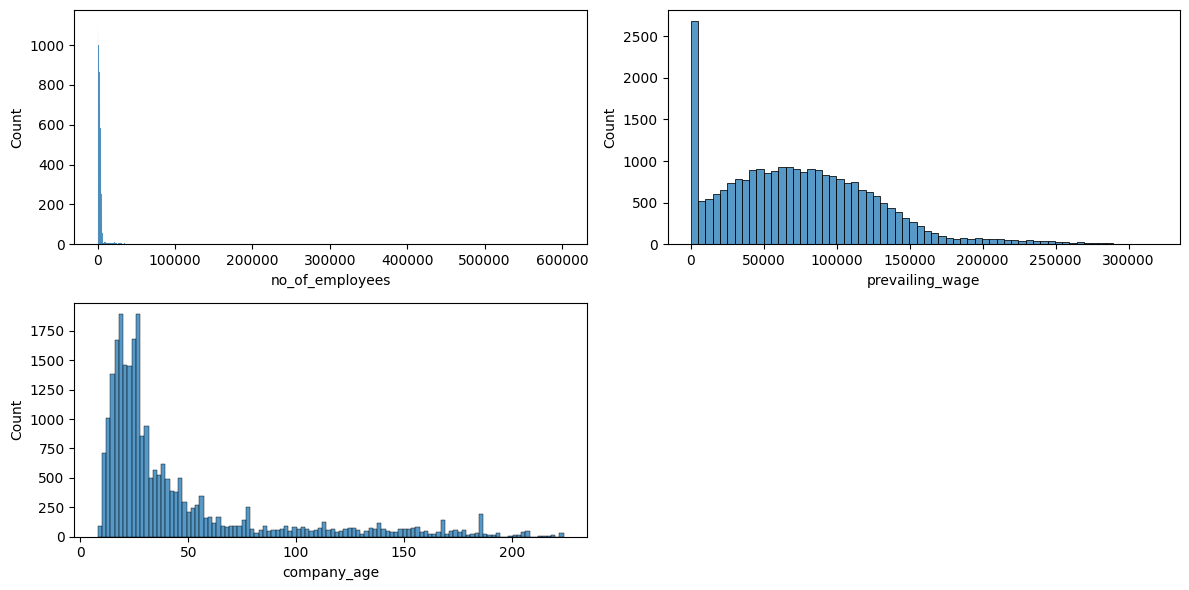

In [18]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=x[col])
    plt.xlabel(col)
    plt.tight_layout()

* No of employees and Copmany age column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

**Checking Skewness**

In [24]:
# Check Skewness
x[continuous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

- Positiviely Skewed : company_age, no_of_employees.
- We can handle outliers and then check the skewness.

## Apply Power Transformer to Check if it can reduces the outliers

In [27]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(x[transform_features])

In [28]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

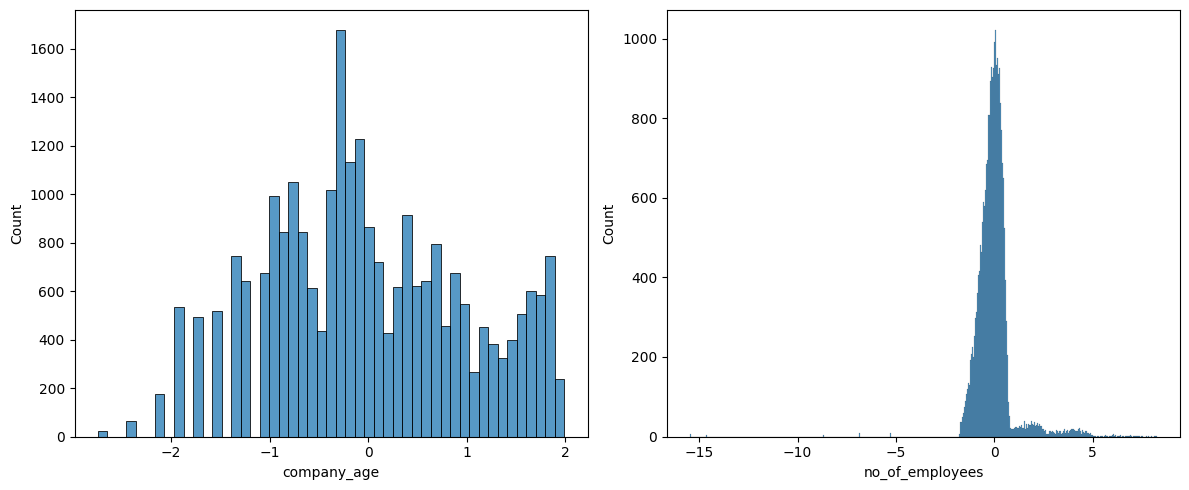

In [29]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col])
    plt.xlabel(col)
    plt.tight_layout()

In [30]:
X_copy.skew(axis=0, skipna=True)

company_age        0.103264
no_of_employees    0.399339
dtype: float64

- Here Yeo-Johnson is used and it supports both positive or negative data for transformation.
- So Power Transformer with yeo-johnson can be used.

In [32]:
for feature in cat_features:
    print(feature,':', df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories** 
* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler** 
* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

**Selecting number features for preprocessing**

In [33]:
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [34]:
# Create Column Transformer with 3 types of transformers
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()
power_transformer = PowerTransformer()
# transform_pipe = Pipeline(steps=[
#     ('transformer', PowerTransformer(method='yeo-johnson'))
# ])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", power_transformer, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [35]:
x = preprocessor.fit_transform(x)

In [36]:
x

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

## resampling

In [37]:
from imblearn.combine import SMOTETomek, SMOTEENN

smt = SMOTEENN(sampling_strategy='minority')
x_res,y_res = smt.fit_resample(x,y)

In [38]:
from sklearn.model_selection import train_test_split
x_train,y_train,x_test,y_test = train_test_split(x_res,y_res)

In [41]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report,ConfusionMatrixDisplay
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [40]:
def evaluate(true,pred):
    acc = accuracy_score(true,pred)
    f1 = f1_score(true,pred)
    precision = precision_score(true,pred)
    recall = recall_score(true,pred)
    roc_auc = roc_auc_score(true,pred)
    return acc, f1, precision, recall, roc_auc

In [42]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [52]:
def evaluate_models(x,y,models:dict):
    acc_list = []
    auc_list = []
    models_list = []
    x_train,x_test,y_train,y_test = train_test_split(x,y)
    for i in range(len(models)):
        model = list(models.values())[i]
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        acc, f1, precision, recall, roc_auc = evaluate(y_test,pred)
        models_list.append(list(models.keys())[i])
        print(list(models.keys())[i])
        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(acc))
        acc_list.append(acc)
        print('- F1 score: {:.4f}'.format(f1))
        print('- Precision: {:.4f}'.format(precision))
        print('- Recall: {:.4f}'.format(recall))
        print('- Roc Auc Score: {:.4f}'.format(roc_auc))
        auc_list.append(roc_auc)

    report = pd.DataFrame(list(zip(models_list,acc_list)),columns=['models','accuracy']).sort_values(by=['accuracy'],ascending=False)  
    return report     
        

In [57]:
base_model_report = evaluate_models(x_res,y_res,models)

Random Forest
----------------------------------
Model performance for Test set
- Accuracy: 0.9539
- F1 score: 0.9581
- Precision: 0.9585
- Recall: 0.9577
- Roc Auc Score: 0.9535
Decision Tree
----------------------------------
Model performance for Test set
- Accuracy: 0.9155
- F1 score: 0.9234
- Precision: 0.9205
- Recall: 0.9264
- Roc Auc Score: 0.9143
Gradient Boosting
----------------------------------
Model performance for Test set
- Accuracy: 0.8913
- F1 score: 0.9002
- Precision: 0.9090
- Recall: 0.8917
- Roc Auc Score: 0.8912
Logistic Regression
----------------------------------
Model performance for Test set
- Accuracy: 0.7364
- F1 score: 0.7524
- Precision: 0.7786
- Recall: 0.7279
- Roc Auc Score: 0.7374


/opt/homebrew/Caskroom/miniforge/base/envs/us_visa_prediction/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K-Neighbors Classifier
----------------------------------
Model performance for Test set
- Accuracy: 0.9388
- F1 score: 0.9449
- Precision: 0.9353
- Recall: 0.9547
- Roc Auc Score: 0.9370
XGBClassifier
----------------------------------
Model performance for Test set
- Accuracy: 0.9334
- F1 score: 0.9393
- Precision: 0.9417
- Recall: 0.9369
- Roc Auc Score: 0.9330
CatBoosting Classifier
----------------------------------
Model performance for Test set
- Accuracy: 0.9318
- F1 score: 0.9376
- Precision: 0.9442
- Recall: 0.9310
- Roc Auc Score: 0.9319
Support Vector Classifier
----------------------------------
Model performance for Test set
- Accuracy: 0.8696
- F1 score: 0.8800
- Precision: 0.8914
- Recall: 0.8688
- Roc Auc Score: 0.8697
AdaBoost Classifier
----------------------------------
Model performance for Test set
- Accuracy: 0.8666
- F1 score: 0.8781
- Precision: 0.8828
- Recall: 0.8735
- Roc Auc Score: 0.8658


In [58]:
base_model_report

,models,accuracy
0,Random Forest,0.953900
4,K-Neighbors Classifier,0.938766
5,XGBClassifier,0.933411
6,CatBoosting Classifier,0.931781
1,Decision Tree,0.915483
2,Gradient Boosting,0.891269
7,Support Vector Classifier,0.869616
8,AdaBoost Classifier,0.866589
3,Logistic Regression,0.736438


In [59]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [60]:
random_cv_models = [
    ('xgb',XGBClassifier(),xgboost_params),
    ('rf',RandomForestClassifier(),rf_params),
    ('knn',KNeighborsClassifier(),knn_params)
]

In [61]:
from sklearn.model_selection import RandomizedSearchCV
model_param = {}
for name,model,params in random_cv_models:
    random = RandomizedSearchCV(model,params,cv=2,verbose=1,n_jobs=-1)
    random.fit(x_res,y_res)
    model_param[name]=random.best_params_

for model_name in model_param:
    print(f"best param for model : {model_name}")
    print(model_param[model_name])
    print('='*30)
    

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
best param for model : xgb
{'min_child_weight': 1, 'max_depth': 9}
best param for model : rf
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': 20}
best param for model : knn
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'brute'}


In [62]:
model_param


{'xgb': {'min_child_weight': 1, 'max_depth': 9},
 'rf': {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 20},
 'knn': {'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'brute'}}

In [64]:
best_models = {
    'rf':RandomForestClassifier(**model_param['rf']),
    'xgb':XGBClassifier(**model_param['xgb']),
    'knn':KNeighborsClassifier(**model_param['knn'])
}

In [65]:
tuned_report = evaluate_models(x_res,y_res,best_models)

rf
----------------------------------
Model performance for Test set
- Accuracy: 0.9430
- F1 score: 0.9476
- Precision: 0.9378
- Recall: 0.9576
- Roc Auc Score: 0.9417
xgb
----------------------------------
Model performance for Test set
- Accuracy: 0.9360
- F1 score: 0.9412
- Precision: 0.9310
- Recall: 0.9516
- Roc Auc Score: 0.9347
knn
----------------------------------
Model performance for Test set
- Accuracy: 0.9586
- F1 score: 0.9623
- Precision: 0.9435
- Recall: 0.9818
- Roc Auc Score: 0.9566


In [66]:
tuned_report

,models,accuracy
2,knn,0.958556
0,rf,0.942957
1,xgb,0.935972


In [72]:
best_model = KNeighborsClassifier(**model_param['knn'])
best_model = best_model.fit(x_res,y_res)
y_pred = best_model.predict(x_res[500:])
score = accuracy_score(y_res[500:],y_pred)
cr = classification_report(y_res[500:],y_pred)

print('final model report')
print('accuracy score', score)
print(cr)

final model report
accuracy score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7343
           1       1.00      1.00      1.00      9337

    accuracy                           1.00     16680
   macro avg       1.00      1.00      1.00     16680
weighted avg       1.00      1.00      1.00     16680



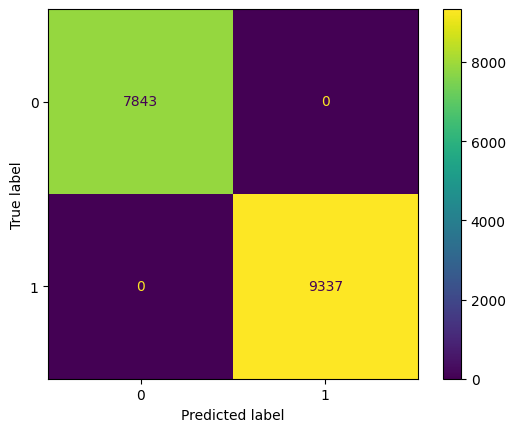

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, x_res, y_res)